In [1]:
# proc je input descriptor extractoru sedy:
# https://answers.opencv.org/question/155/do-inputs-of-descriptor-extractors-are-required-to-be-grayscale/

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
import os
import PIL
import PIL.Image
import pathlib


## Preprocessing

In [4]:
# funkce zmensi obrazky na scale % sve puvodni velikosti
def downscale_pics(pics, scale=30):
    resized = []
    for img in pics:
         
        width = int(img.shape[1] * scale / 100)
        height = int(img.shape[0] * scale / 100)
        dim = (width, height)

        resized.append(cv2.resize(img, dim, interpolation = cv2.INTER_AREA))
    
    return resized


In [5]:
# nacte obrazky
def load_and_preprocess(path):
    
    # adresar s obrazy
    data_dir = pathlib.Path(path)

    # zobrazeni poctu obrazu v adresari
    image_count = len(list(data_dir.glob('*')))
    print(f"Celkem obrazů v adresáři {path}: {image_count}")


    paintings_path = list(data_dir.glob('*'))
    paintings_path = [str(path) for path in paintings_path]
    
    # ted pracuji pouze s sedymi obrazy
    paintings_gray = [cv2.imread(painting_path,  cv2.IMREAD_GRAYSCALE) for painting_path in paintings_path]
    paintings = paintings_gray
   
    # nacteni vsech obrazu
    #paintings = [cv2.imread(painting_path) for painting_path in paintings_path]
    #paintings_raw = paintings
    
    # konvertovani do rgb
    #paintings = [cv2.cvtColor(painting, cv2.COLOR_BGR2RGB) for painting in paintings]
    
    
    # Zmenseni obrazku ma na mem datasetu velmi pozitivni vliv!
    paintings = downscale_pics(paintings)
    
    return paintings


In [6]:
stolen_art_dir_path = "./mydata-stolen/"
stolen_paintings = load_and_preprocess(stolen_art_dir_path)


Celkem obrazů v adresáři ./mydata-stolen/: 9


In [7]:
suspect_paintings_dir_path = "./mydata-suspects/" 
suspect_paintings = load_and_preprocess(suspect_paintings_dir_path)

Celkem obrazů v adresáři ./mydata-suspects/: 17


In [8]:
def display_compared(img1, img2):
    # Display traning image and testing image
    fx, plots = plt.subplots(1, 2, figsize=(20,10))

    plots[0].set_title("Stolen Image")
    plots[0].imshow(img1)

    plots[1].set_title("Comparing to")
    plots[1].imshow(img2)

In [9]:
#display_compared(stolen_paintings_gray[1], suspect_paintings_gray[0])

In [10]:
# Vytvoření ORB objektu
orb = cv2.ORB_create(nfeatures=500)

In [11]:
def visualize_keypoints(image, keypoints):
    
    keypoints_without_size = np.copy(image)
    keypoints_with_size = np.copy(image)

    cv2.drawKeypoints(image, keypoints, keypoints_without_size, color = (0, 255, 0))

    cv2.drawKeypoints(image, keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # VYKRESLOVANI KEYPOINTS:
    
    # Display image with and without keypoints size
    fx, plots = plt.subplots(1, 2, figsize=(20,10))

    plots[0].set_title("Train keypoints With Size")
    plots[0].imshow(keypoints_with_size)

    plots[1].set_title("Train keypoints Without Size")
    plots[1].imshow(keypoints_without_size)
    
    print("Number of Keypoints Detected In The Stolen Image: ", len(keypoints))

## Spuštění algoritmu na obrázcích v databázi

In [12]:
orb_results = []

for index, _ in enumerate(stolen_paintings):

    orb_res = orb.detectAndCompute(stolen_paintings[index], None)
    orb_results.append(orb_res)

    sp_keypoints, sp_descriptors = orb_res
    
    #visualize_keypoints(stolen_paintings[index], sp_keypoints)

### Zvolení hledaného obrazu

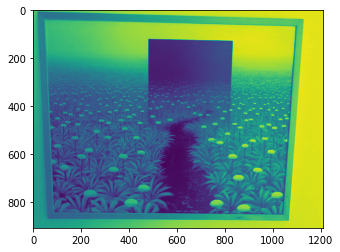

In [13]:
# obraz ktery budu vyhledavat v databazi:
suspected_image = suspect_paintings[6] 
suspect_keypoints, suspect_descriptor = orb.detectAndCompute(suspected_image, None)
plt.imshow(suspected_image)


## Matching nalezeného obrazu s obrazy v DB  pomocí Brute Force Matcher

BFMatcher - Obsahuje parametr crossCheck, údajně dobrá alternativa k ratio testu, ale mně nefunguje dobře. Znamená to, že namatchuje pouze body, které jsou si nejpodobnější navzájem, tzn. pro žádný z dvojice neexistuje v druhém obraze lepší match. Pokud ho dám na False, matcher namatchuje všechny body a výsledek je uplně k ničemu. Pokud na true, matcher namatchuje cca polovinu bodů, ale u všech obrazů a je proto taky k ničemu.

Mnohem lépe se mi osvědčila kombinace knnMatch a ratio testu.

**crossCheck se samozřejmě nedá kombinovat s knnMatch ! !**




zdroj: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

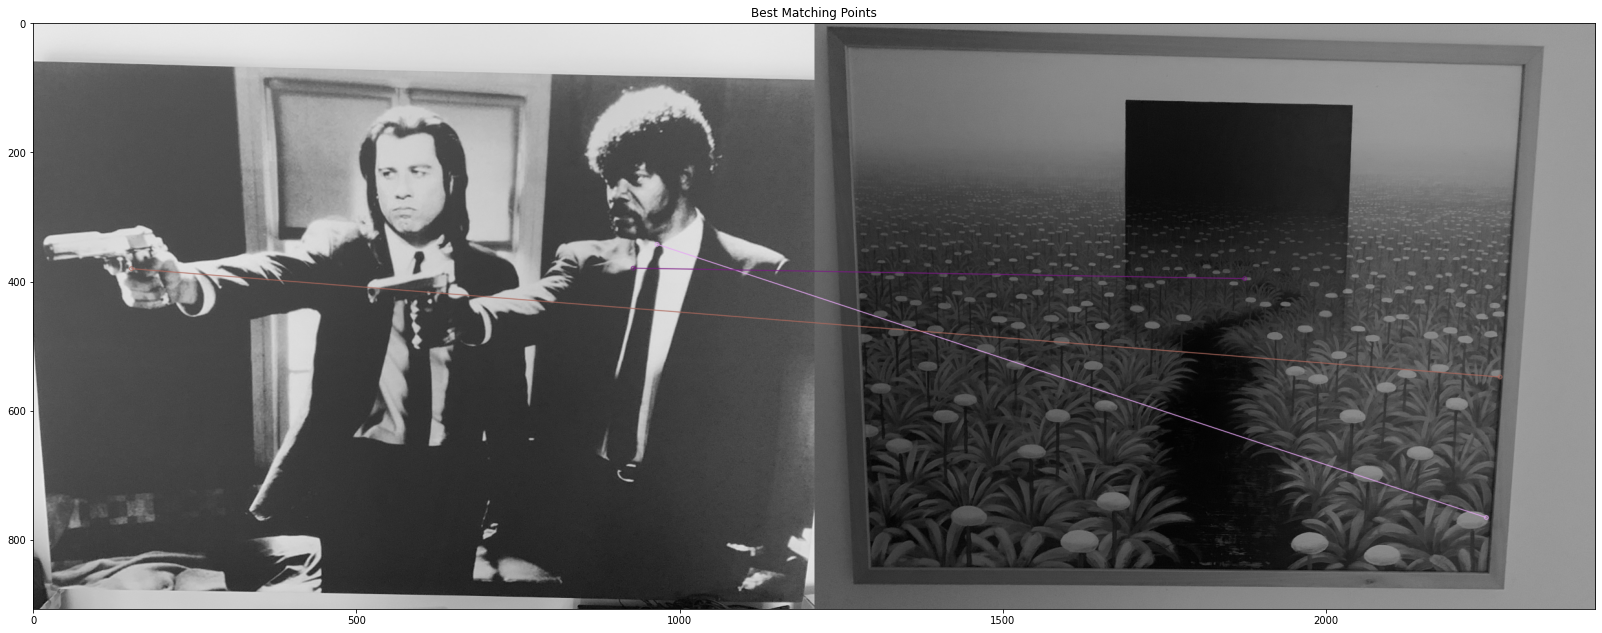

Celkový počet dobrých match (po ratio testu):  3


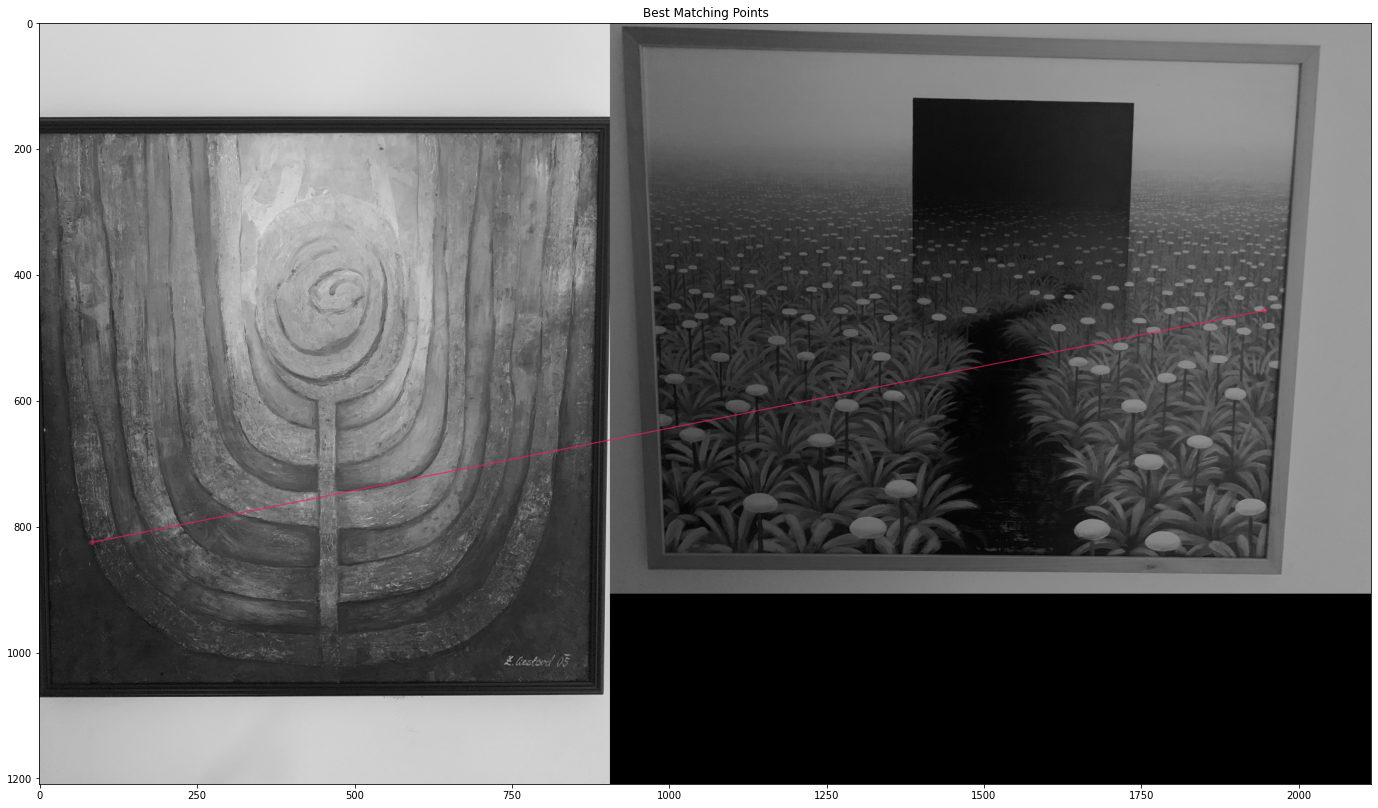

Celkový počet dobrých match (po ratio testu):  1


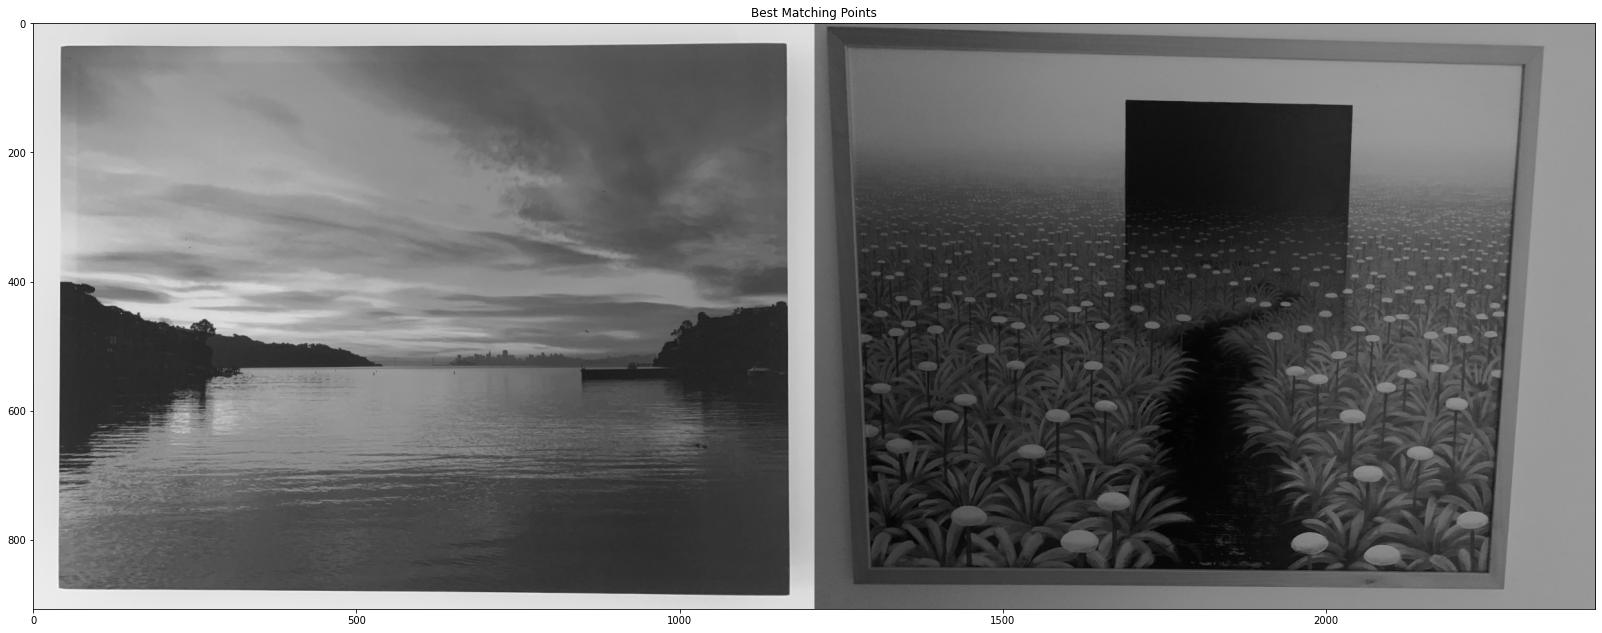

Celkový počet dobrých match (po ratio testu):  0


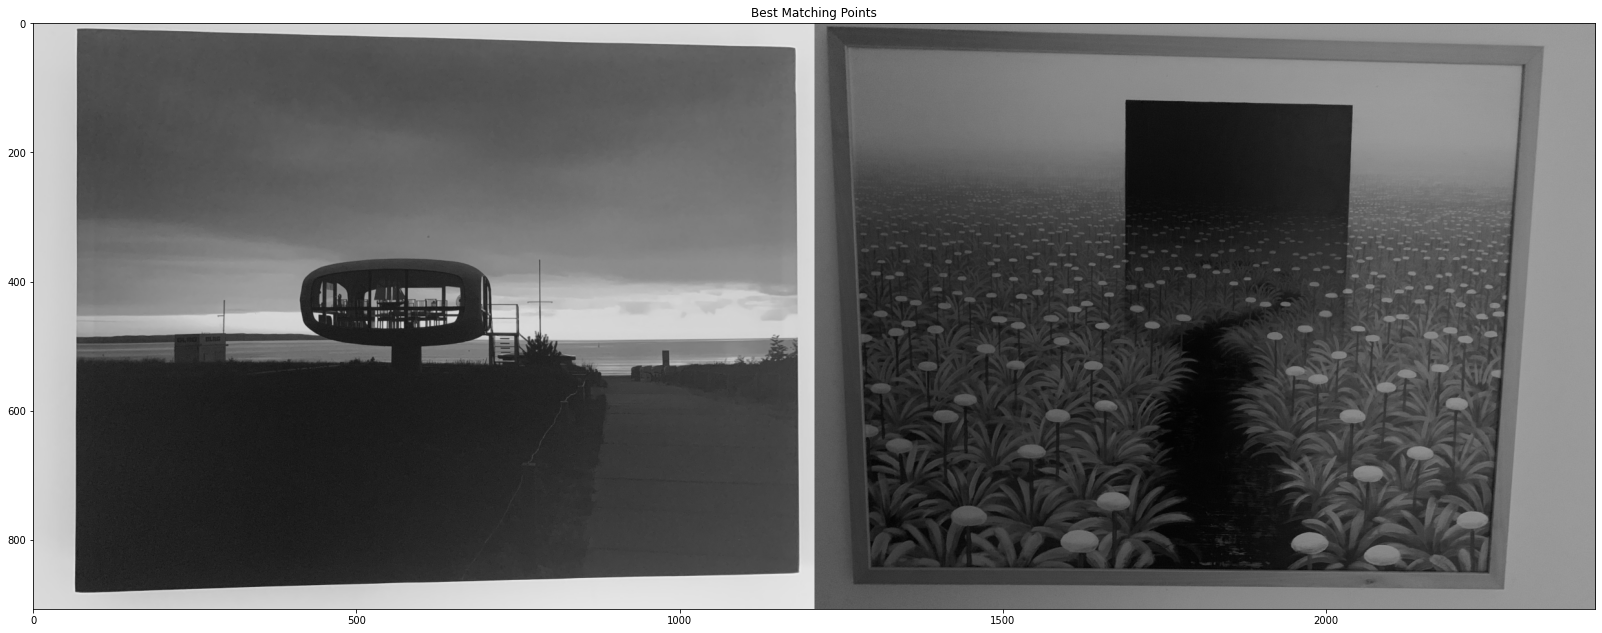

Celkový počet dobrých match (po ratio testu):  0


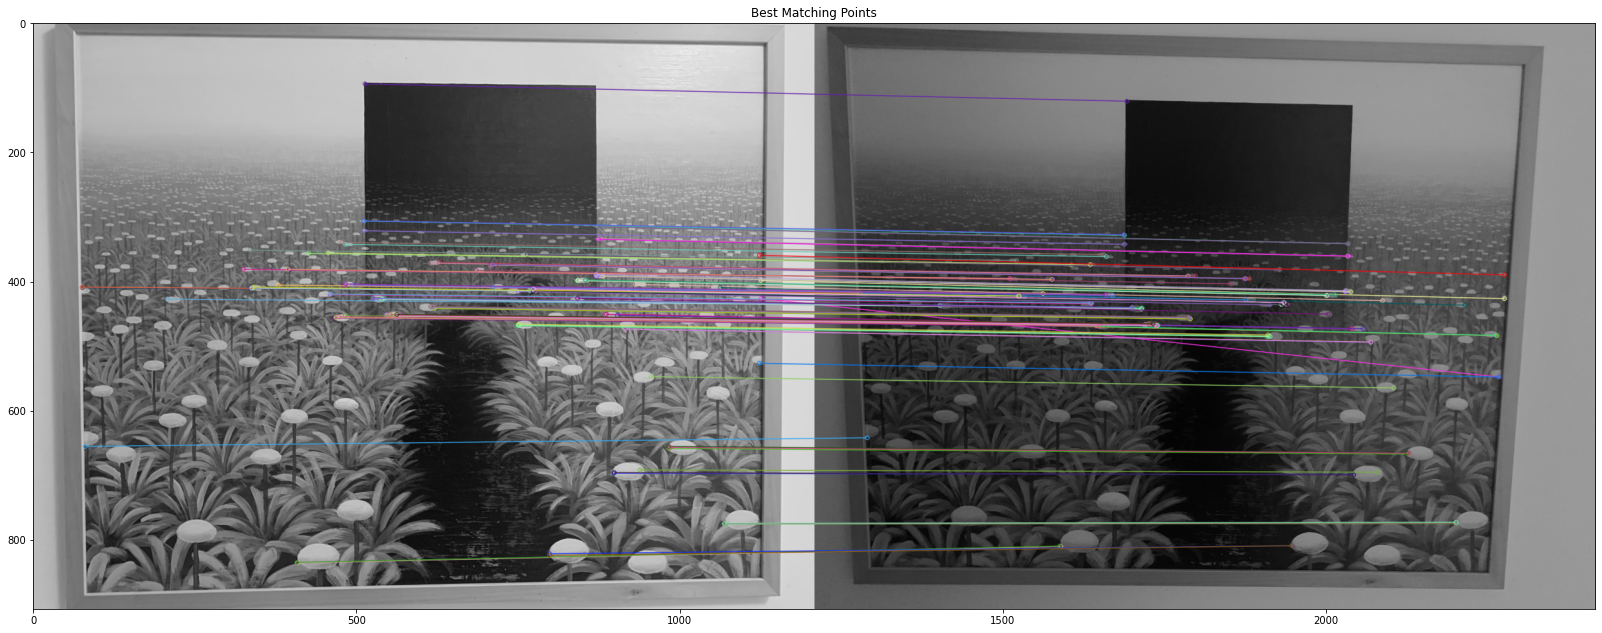

Celkový počet dobrých match (po ratio testu):  113


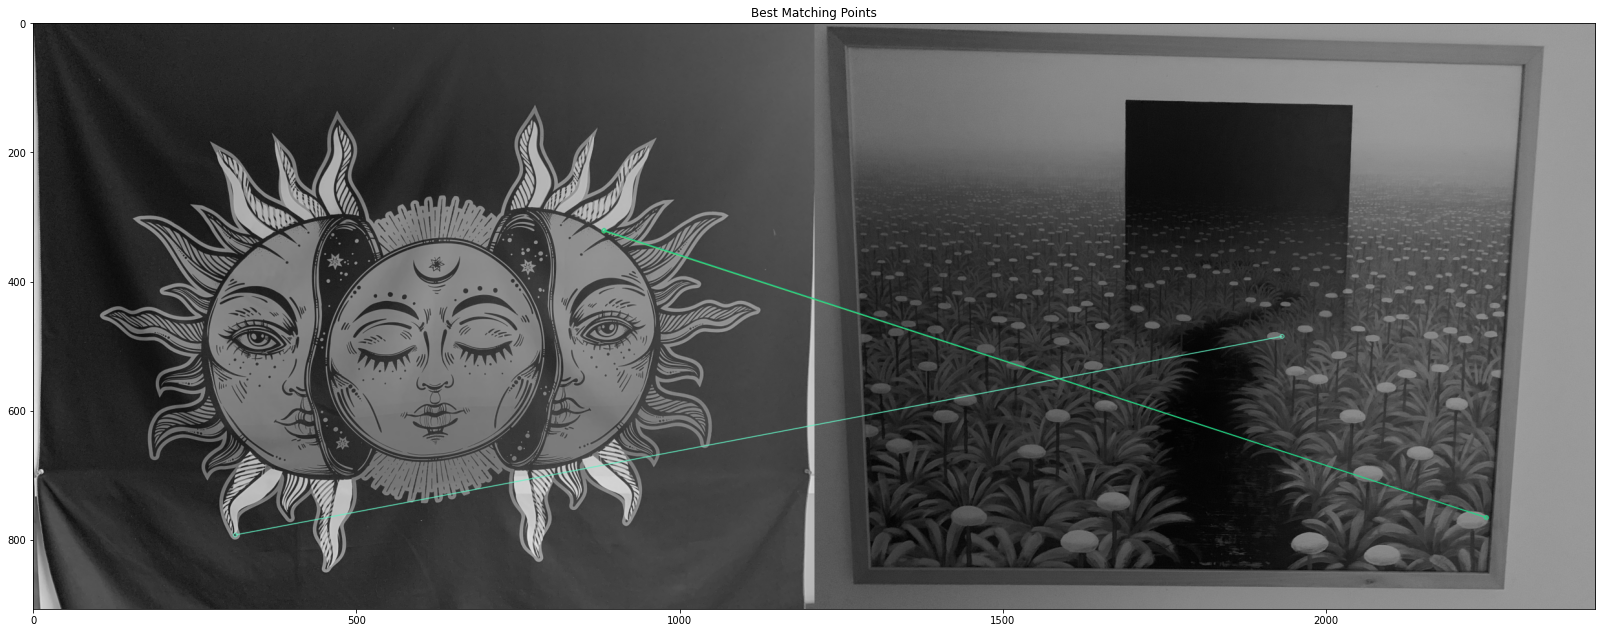

Celkový počet dobrých match (po ratio testu):  3


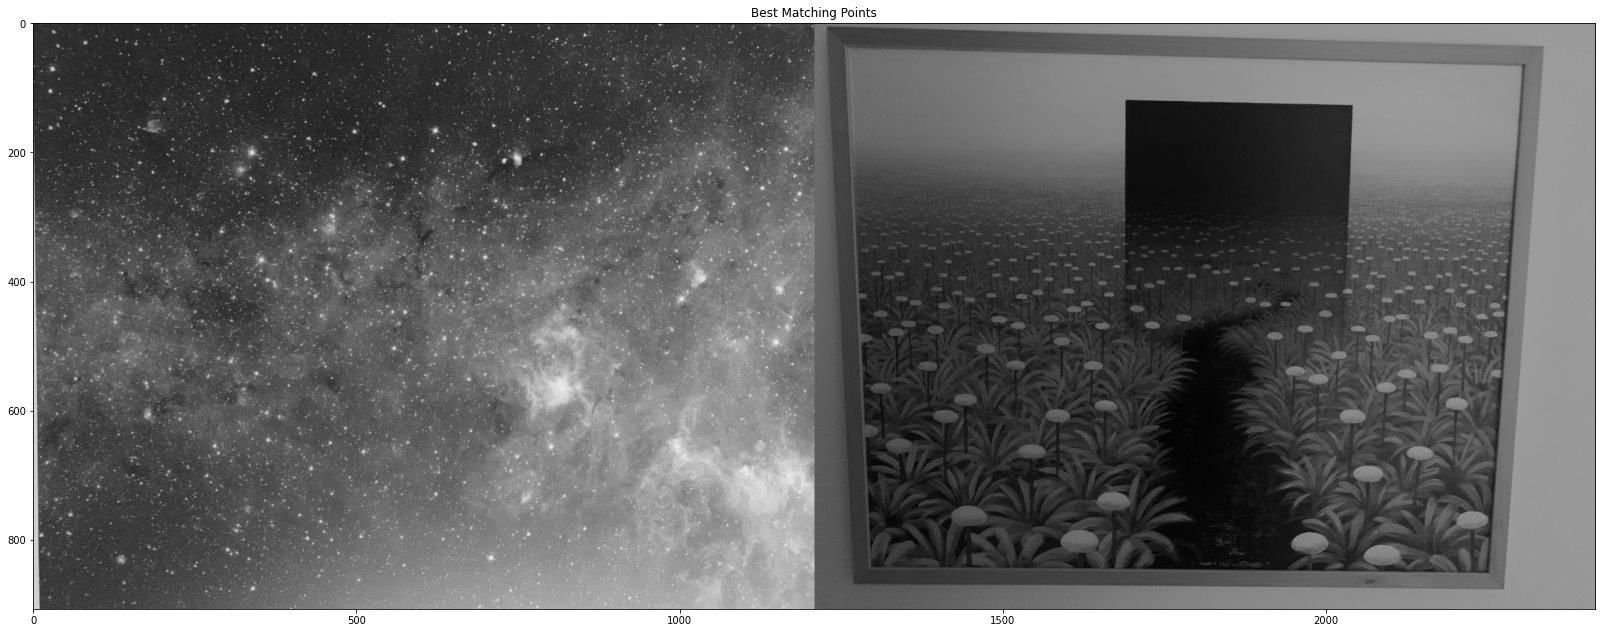

Celkový počet dobrých match (po ratio testu):  0


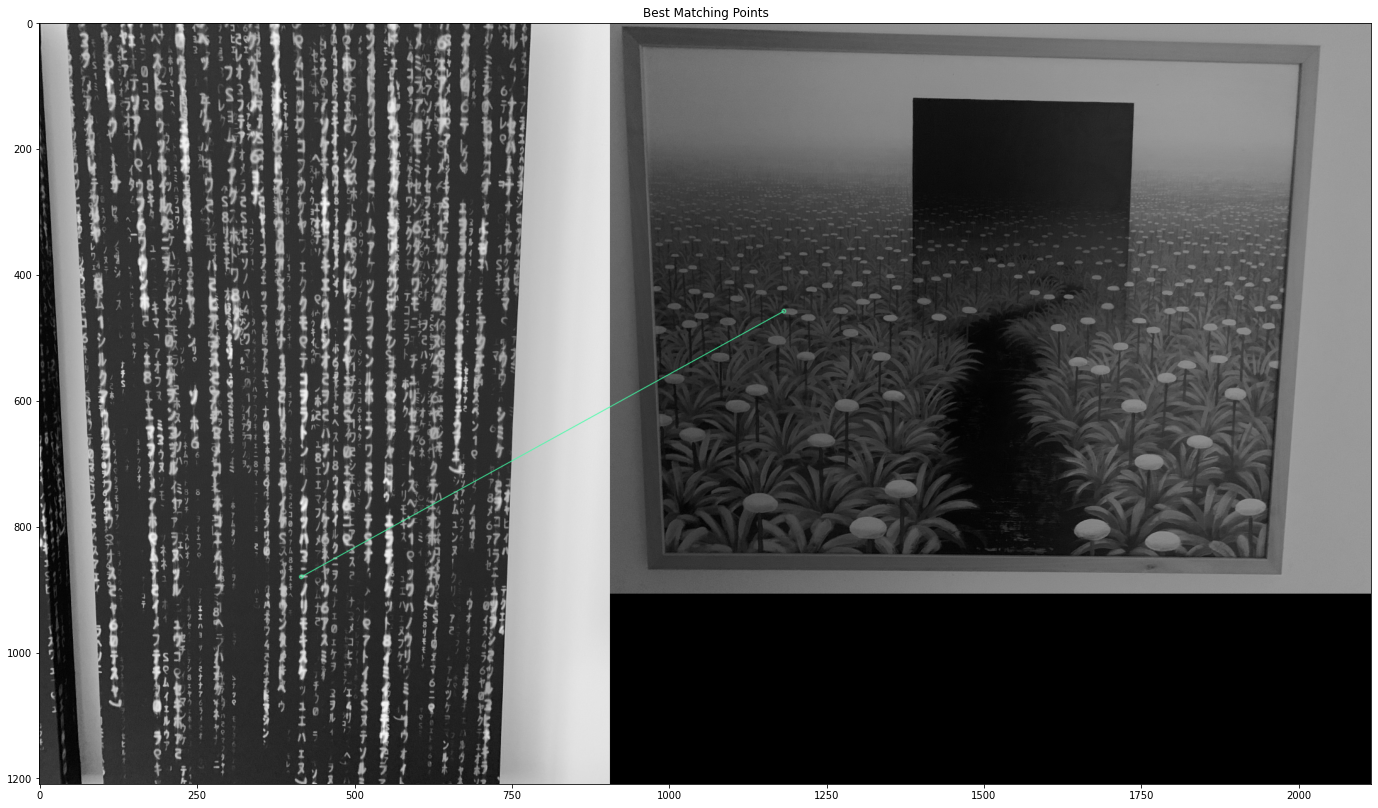

Celkový počet dobrých match (po ratio testu):  1


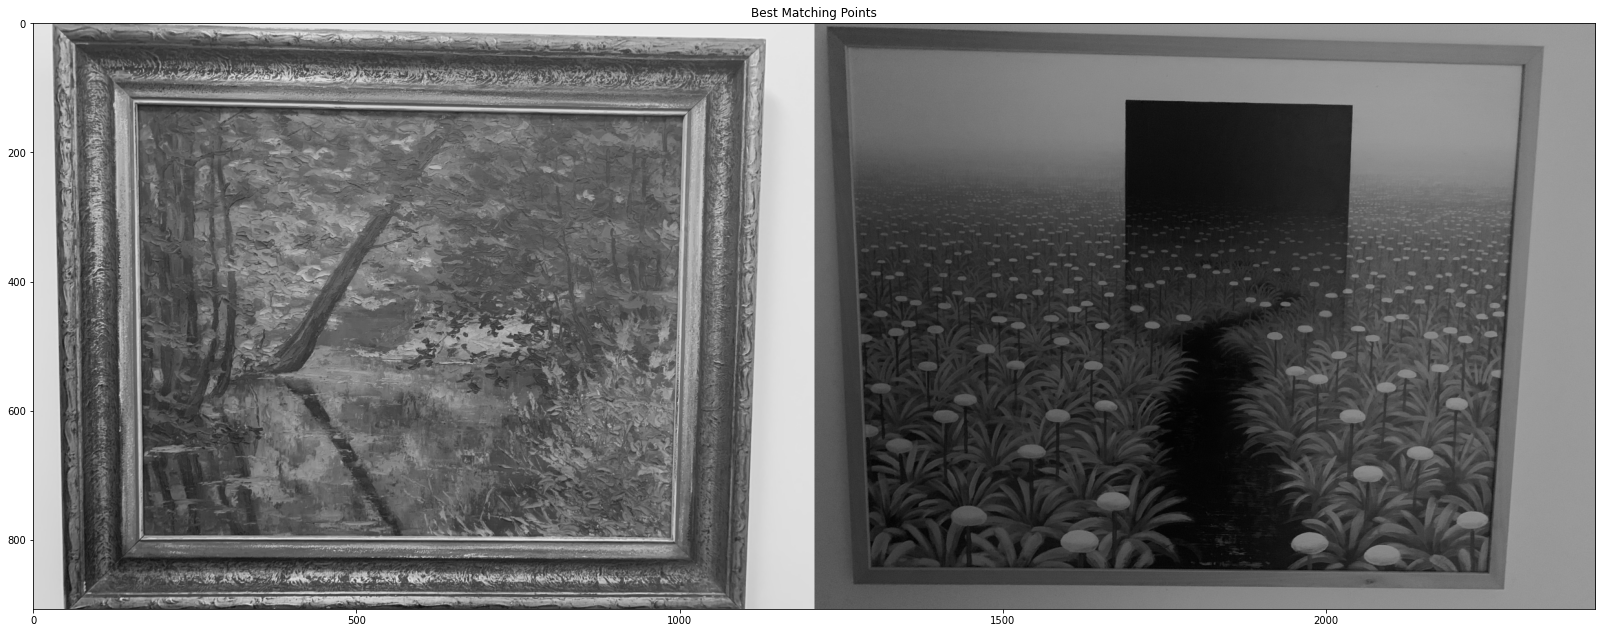

Celkový počet dobrých match (po ratio testu):  0


In [14]:
kbfm = 2

for index, stolen_res in enumerate(orb_results):
    stolen_keypoints, stolen_descriptor = stolen_res

    # Cross check parametr
    bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck = False)

        
    
    # Perform the matching between the ORB descriptors of the training image and the test image
    matches = bf.knnMatch(stolen_descriptor, suspect_descriptor, kbfm)
    # deskriptor = "fingerprint" keypointu, vektor 0 a 1, napr. BRIEF rozmaze misto a z toho spocita vektor
    # ORB muze pouzivat rBRIEF, tzn. pocita i s rotaci obrazu
    
   
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    result = cv2.drawMatchesKnn(stolen_paintings[index], stolen_keypoints, suspected_image, suspect_keypoints, good, None, flags = 2)
    
    # Display the best matching points
    plt.rcParams['figure.figsize'] = [28.0, 14.0]
    plt.title('Best Matching Points')
    plt.imshow(result)
    plt.show()

    # Print total number of matching points between the training and query images
    print("Celkový počet dobrých match (po ratio testu): ", len(good))

## FLANN Based Matcher

In [15]:
# 1. parametr FlannBasedMatcheru
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

In [16]:
# 2. parametr FlannBasedMatcheru
search_params = dict(checks=50)   # or pass empty dictionary

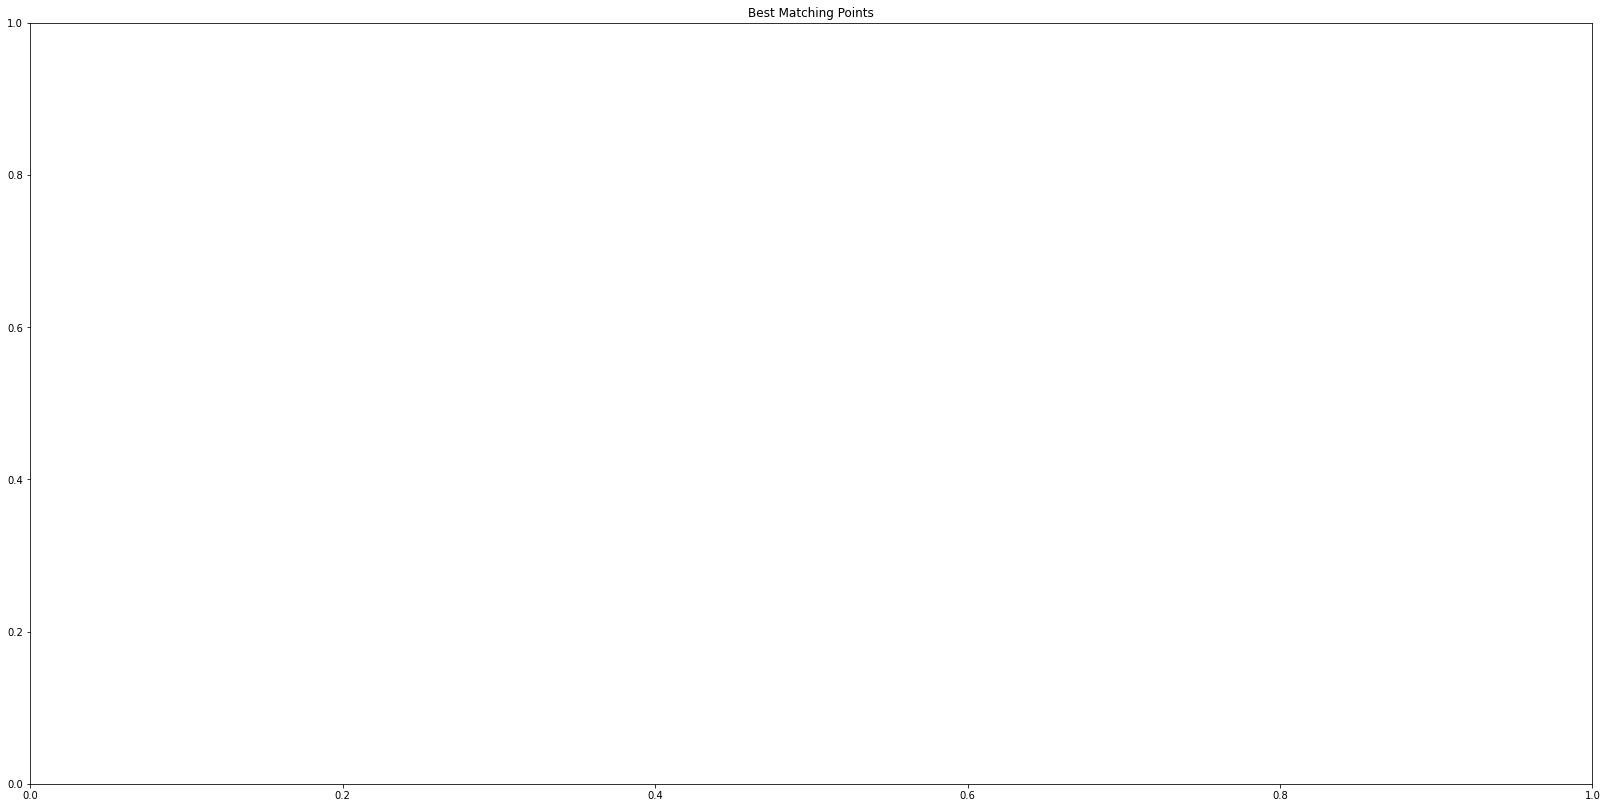

Pocet prijatelnych matchu:  3


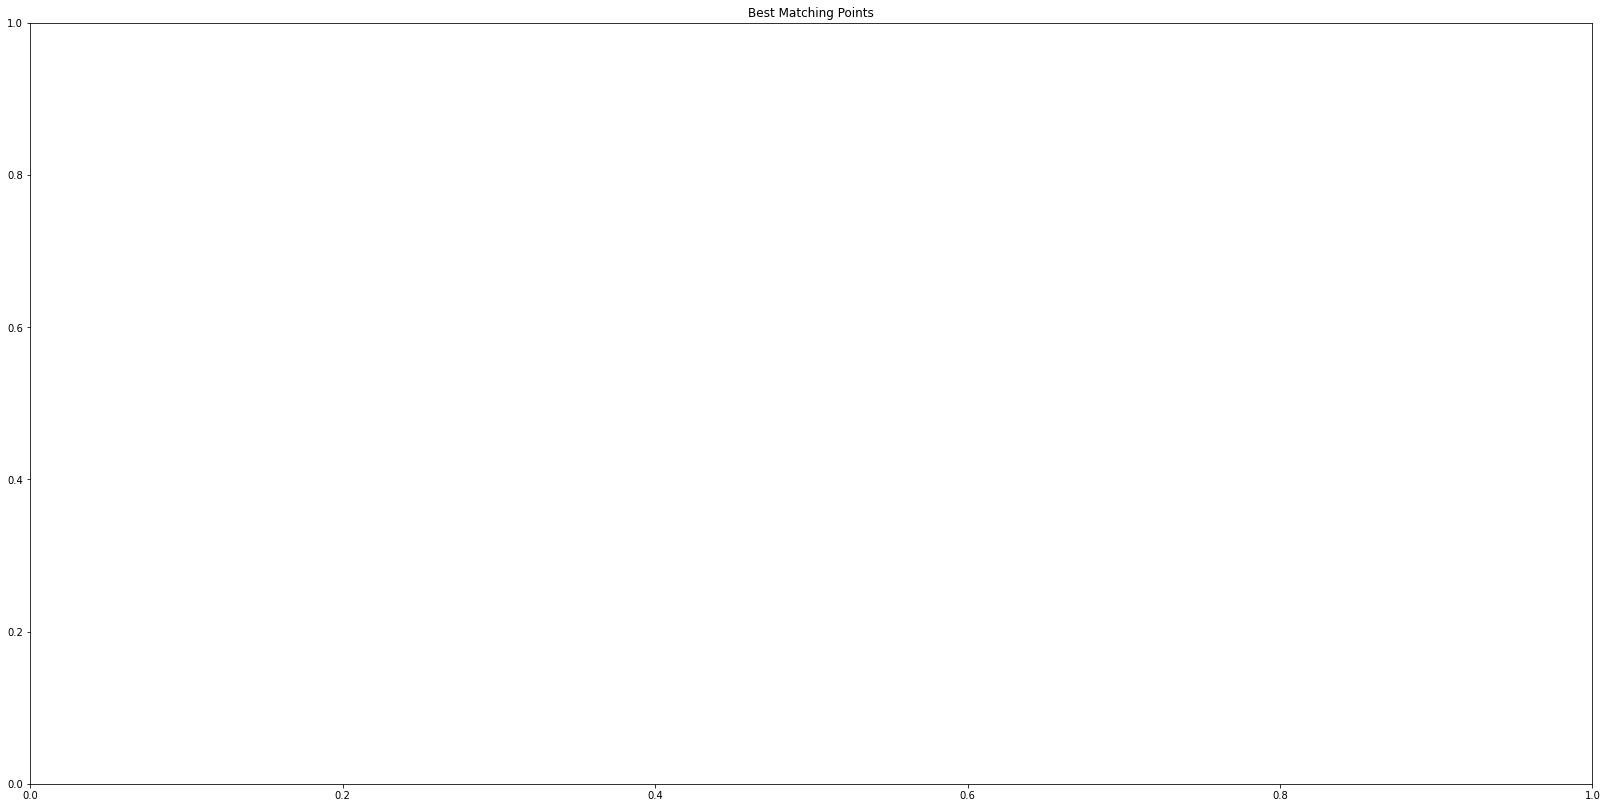

Pocet prijatelnych matchu:  2


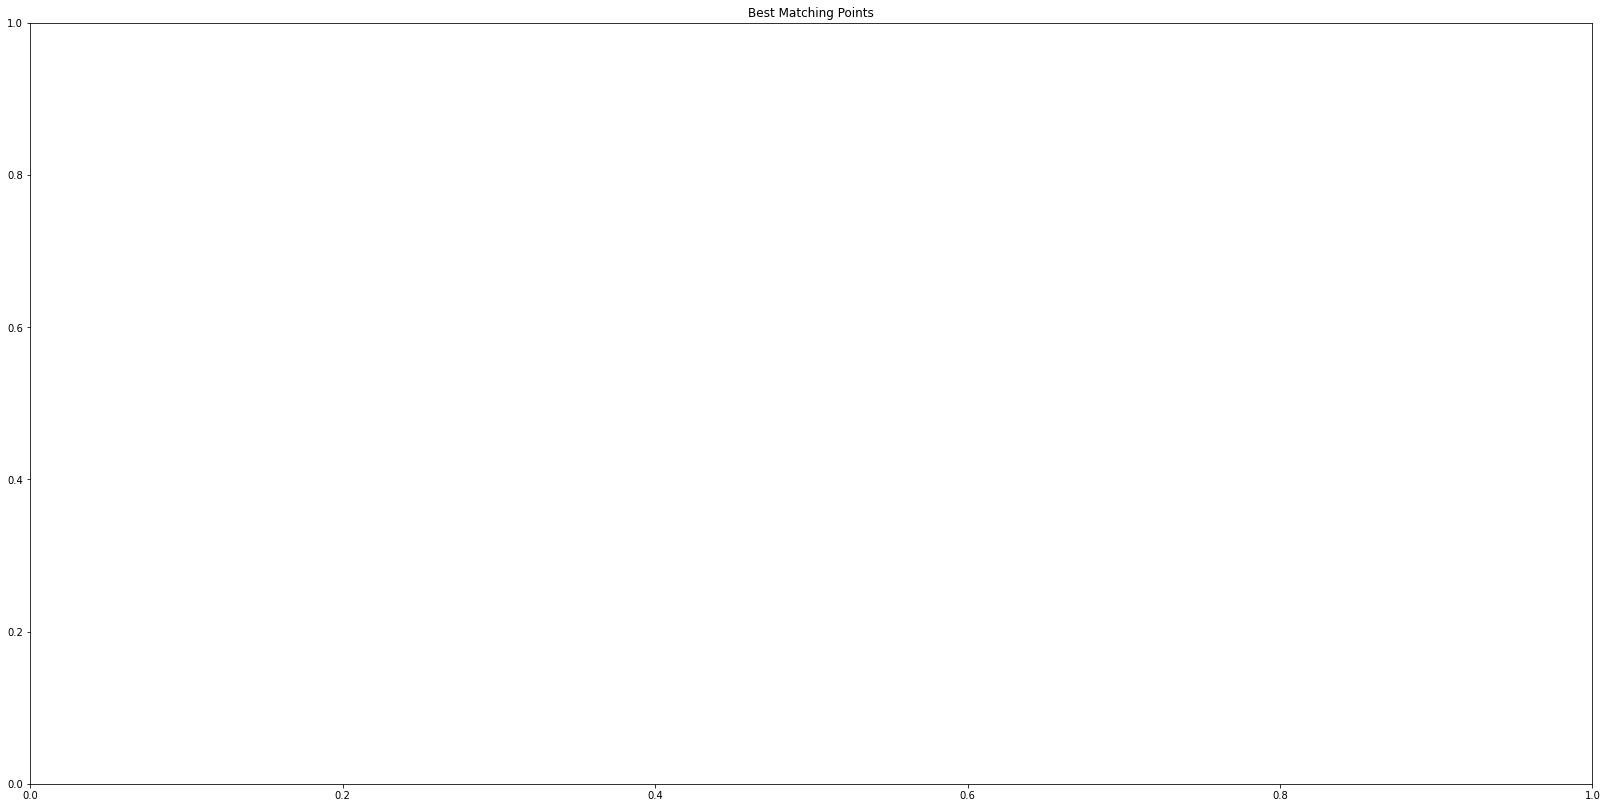

Pocet prijatelnych matchu:  2


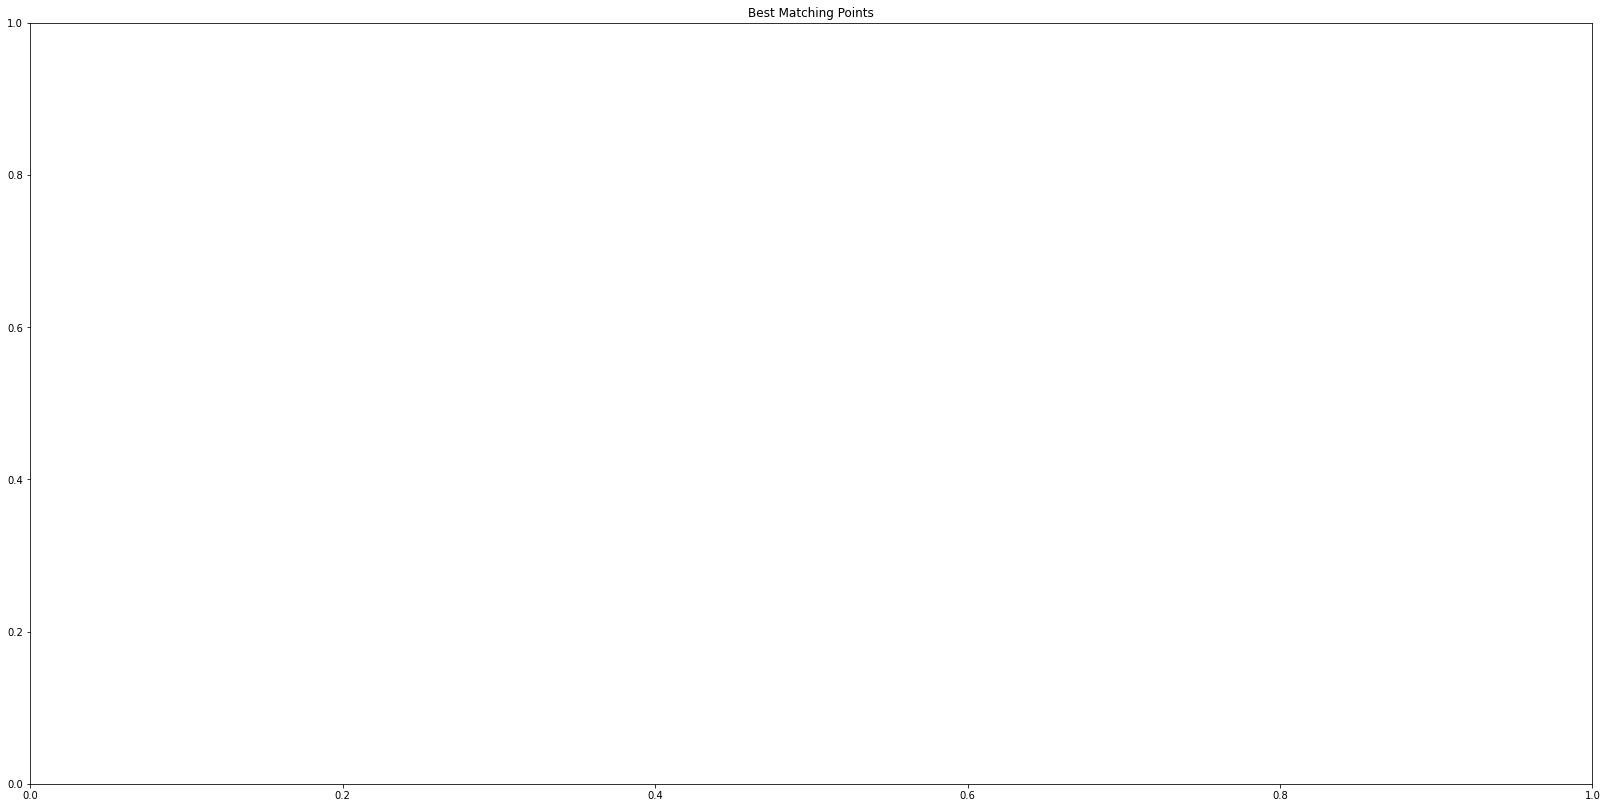

Pocet prijatelnych matchu:  0


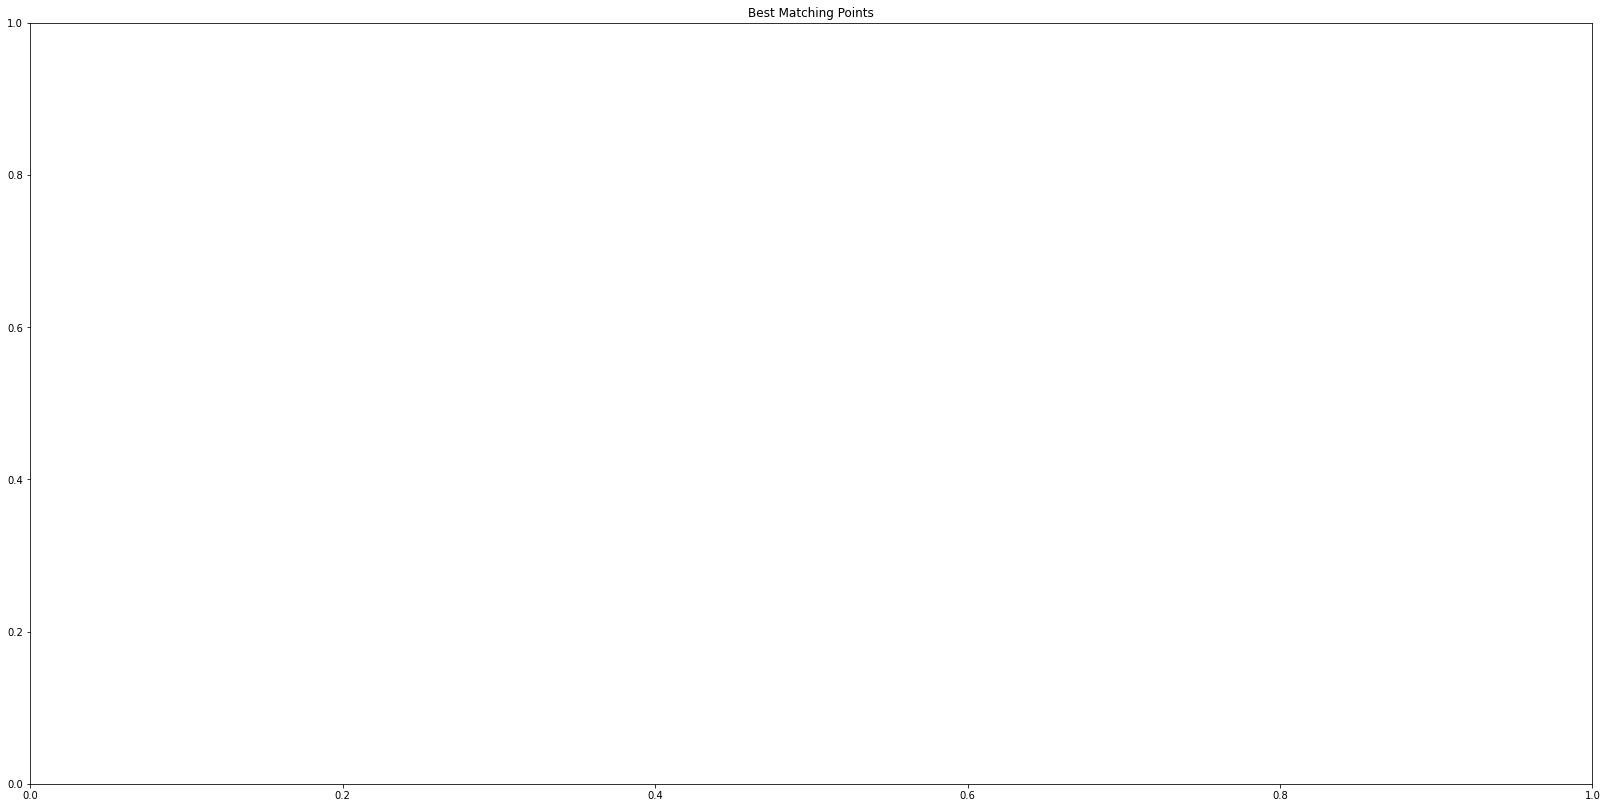

Pocet prijatelnych matchu:  110


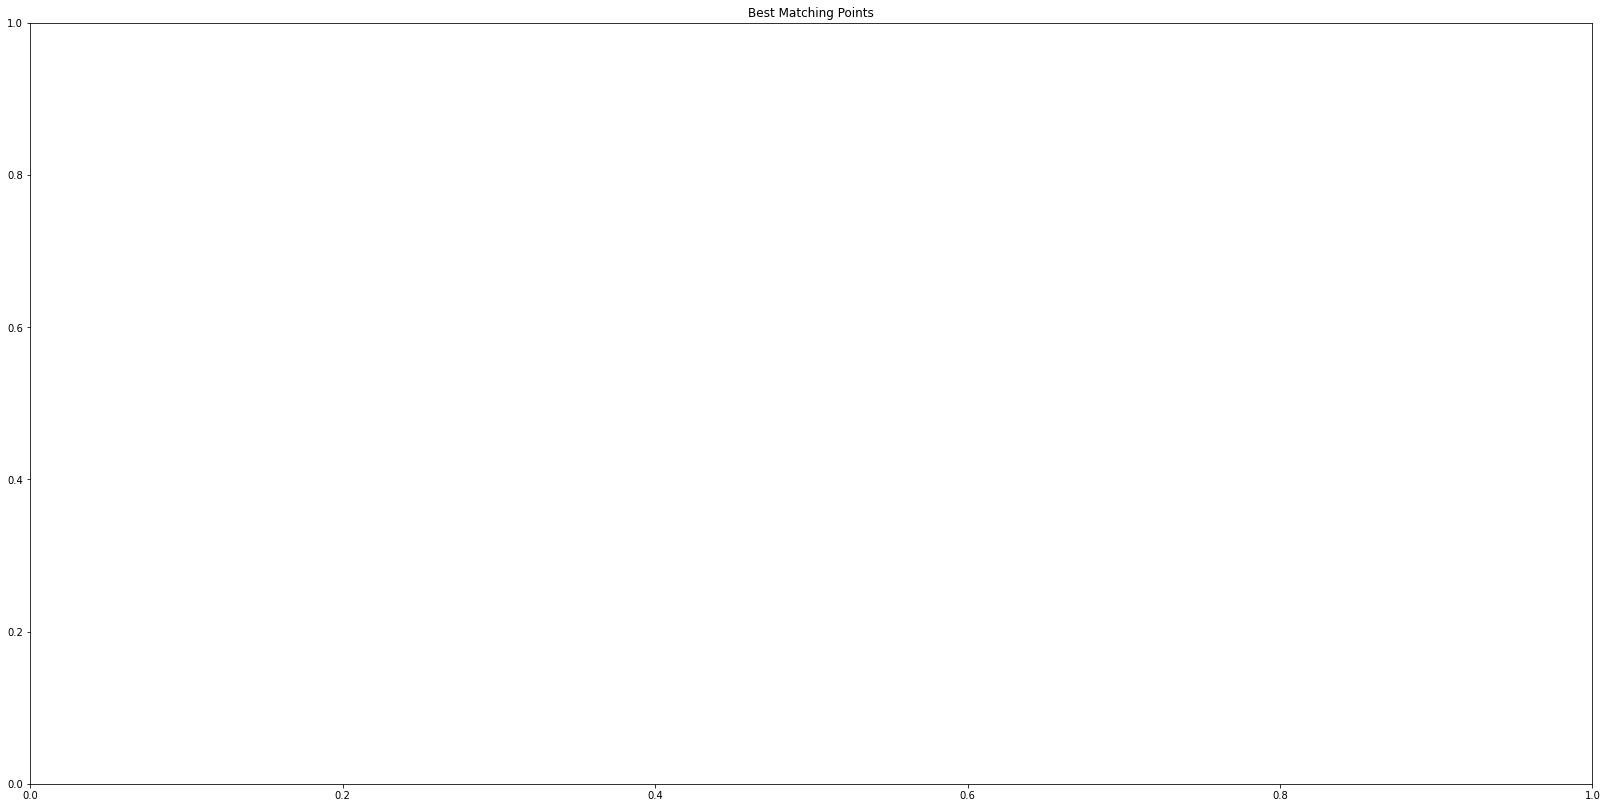

Pocet prijatelnych matchu:  7


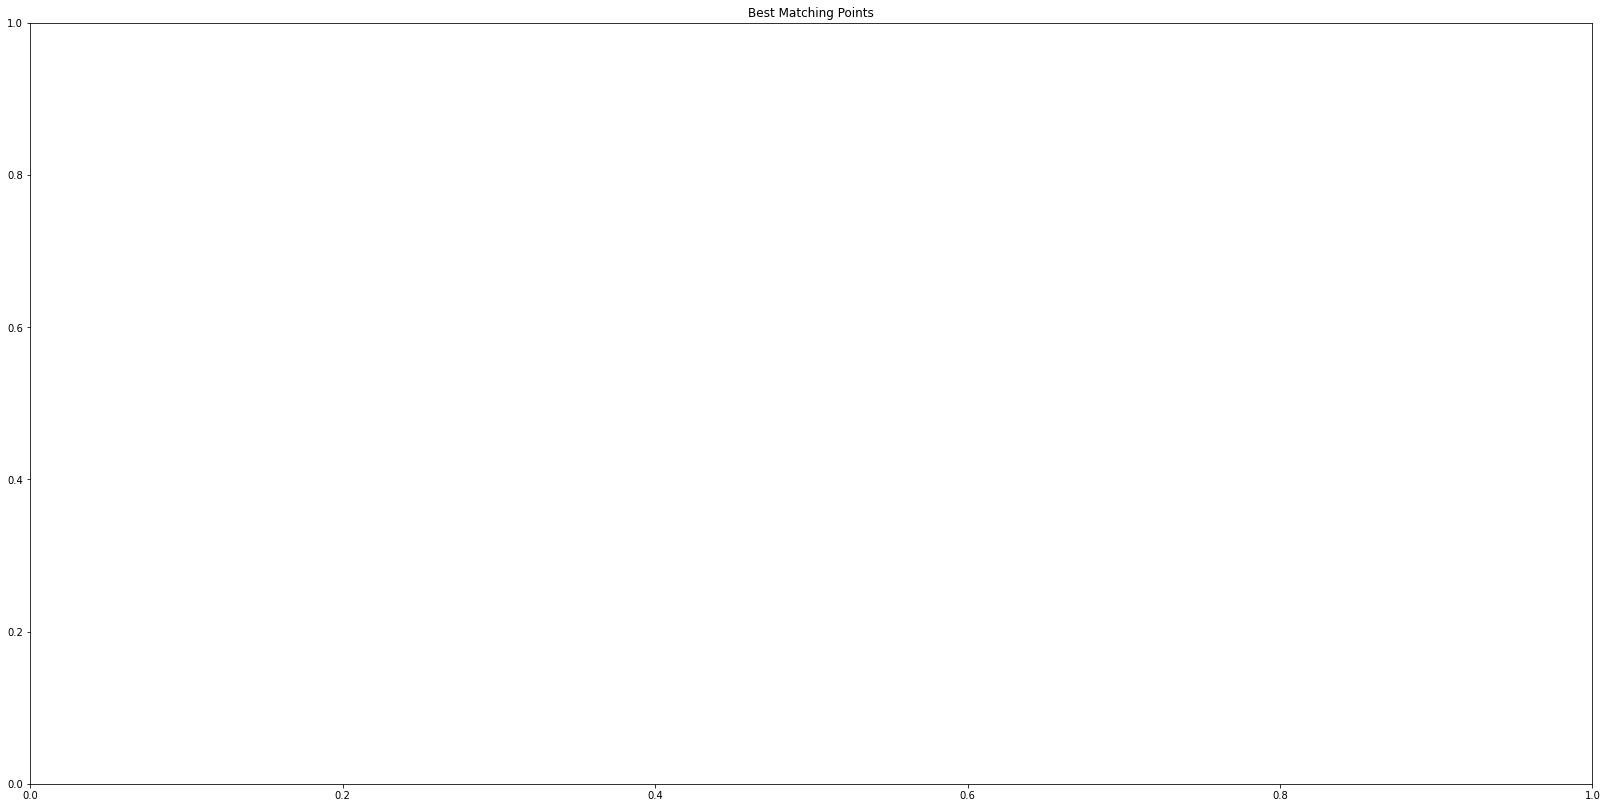

Pocet prijatelnych matchu:  1


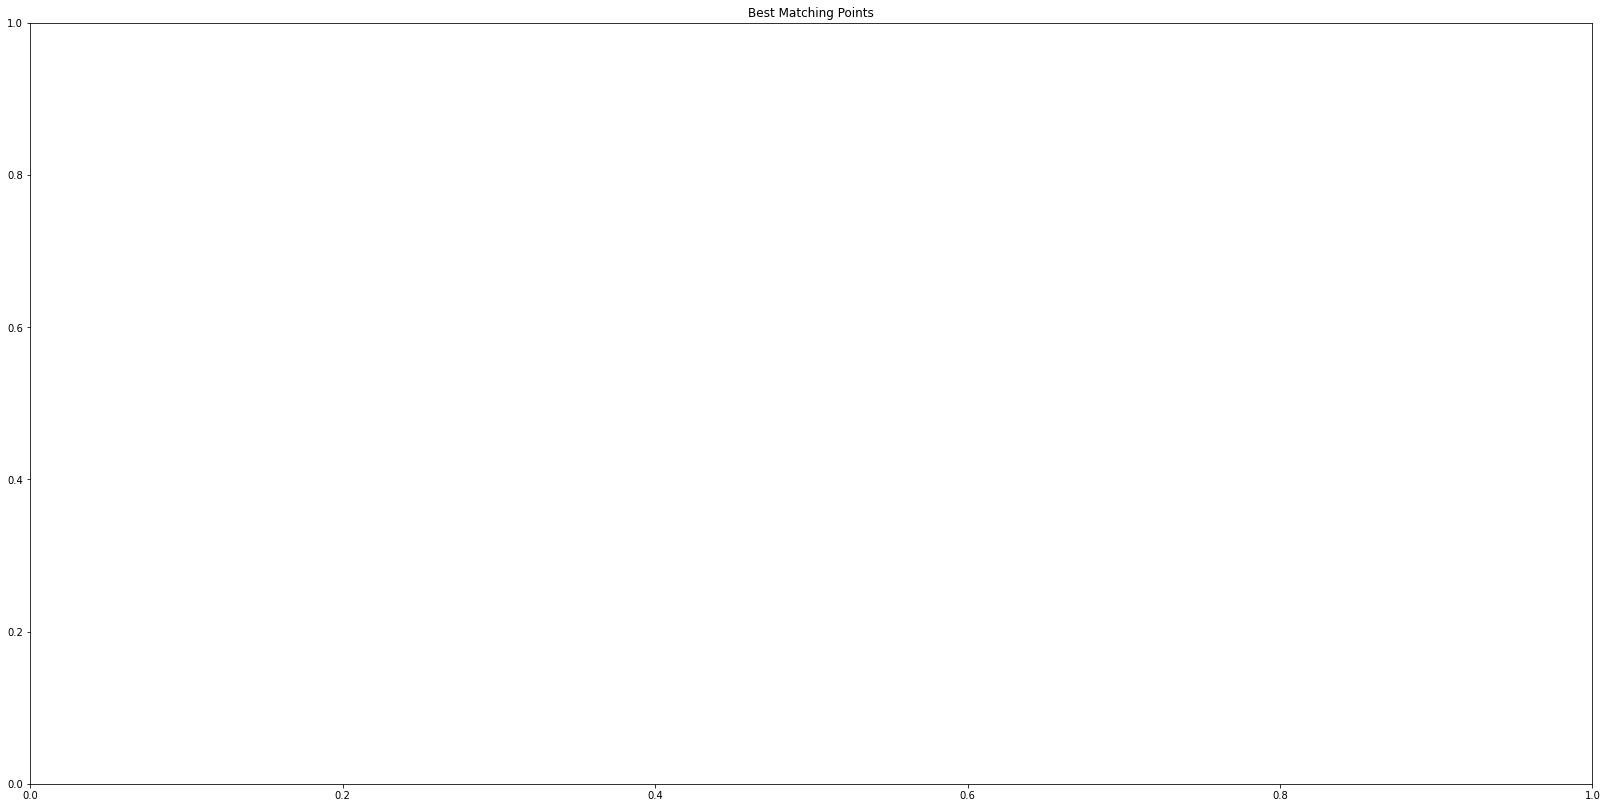

Pocet prijatelnych matchu:  2


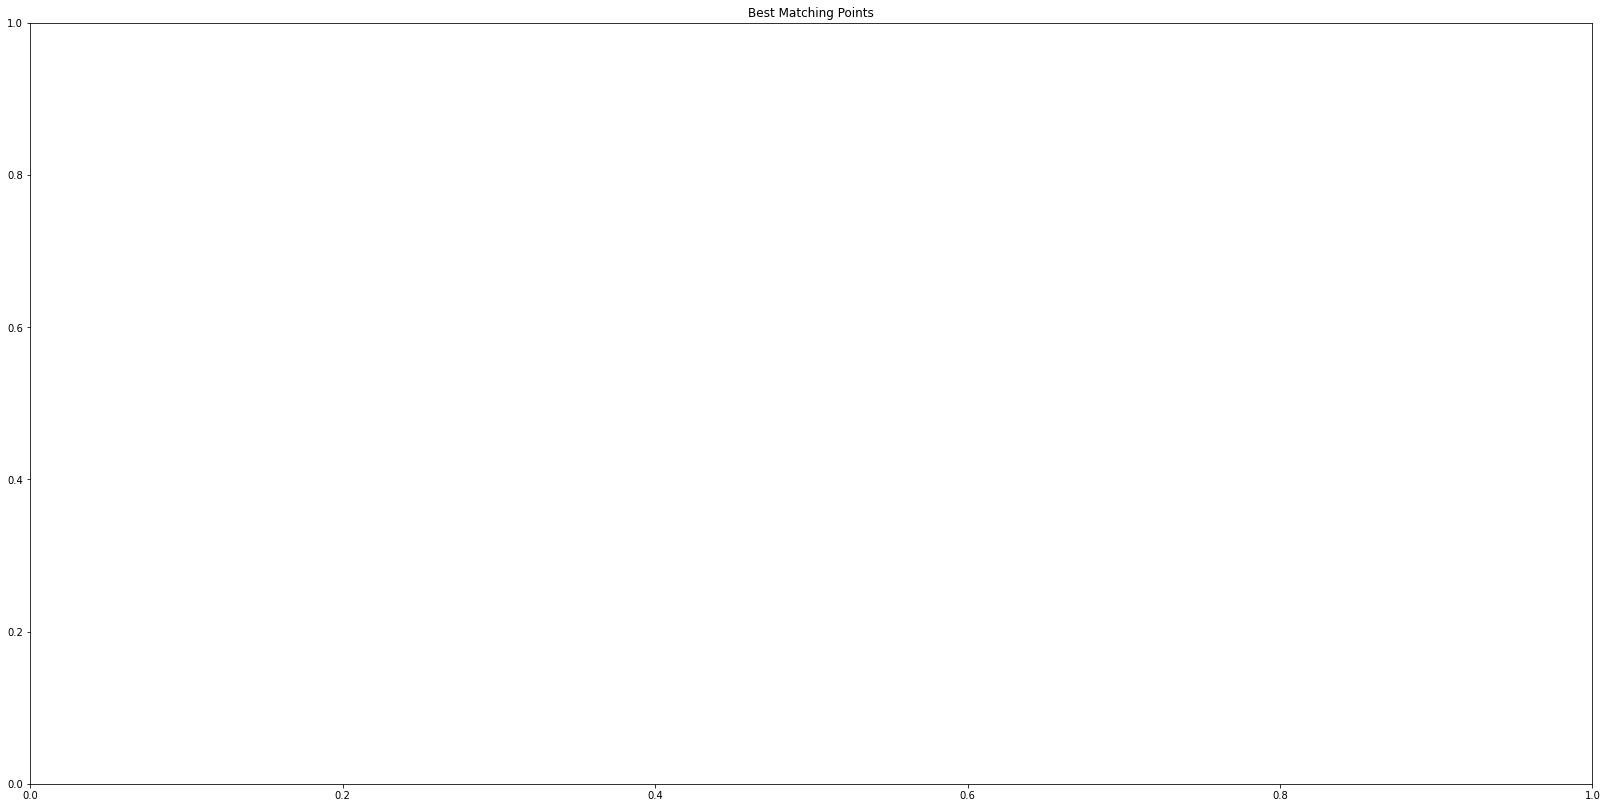

Pocet prijatelnych matchu:  2


In [19]:
k = 2 # Urcuje kolik matches chceme pro kazdy bod (knnMatches)

for index, stolen_res in enumerate(orb_results):
    stolen_keypoints, stolen_descriptor = stolen_res

    # Cross check parametr
    flann = cv2.FlannBasedMatcher(index_params, search_params)

        
    
    # Perform the matching between the ORB descriptors of the training image and the test image
    matches = flann.knnMatch(stolen_descriptor, suspect_descriptor, k)
    # deskriptor = "fingerprint" keypointu, vektor 0 a 1, napr. BRIEF rozmaze misto a z toho spocita vektor
    # ORB muze pouzivat rBRIEF, tzn. pocita i s rotaci obrazu
    
    ok_matches_num = 0
    
    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]
    # ratio test as per Lowe's paper
    for i, candidates in enumerate(matches):
        if (len(candidates)<2):
            continue # nedostatek bodu pro porovnani
        m, n = candidates    
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            ok_matches_num = ok_matches_num + 1 
    
    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

    result = cv2.drawMatchesKnn(stolen_paintings[index], stolen_keypoints, suspected_image, suspect_keypoints,
                             matches, None, **draw_params)
    
    # Display the best matching points
    plt.rcParams['figure.figsize'] = [28.0, 14.0]
    plt.title('Best Matching Points')
    plt.imshow(result)
    plt.show()

    
    print("Pocet prijatelnych matchu: ", ok_matches_num)

In [18]:
# nápad na vylepšení: porovnávat směry vektoru, vyhodit outsidery
# + zkoumat relativni polohu